In [42]:
import os
from keras import applications
from keras import models
from keras.preprocessing import image
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils.np_utils import to_categorical 
from keras.callbacks import ModelCheckpoint
from keras import Model
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.utils import layer_utils, np_utils
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from keras.applications.resnet50 import preprocess_input
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import class_weight
import seaborn as sn
import pandas as pd
from scipy import interp
from itertools import cycle
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

In [8]:
image_width = 224
image_height = 224

# Change the batchsize according to your system RAM
batch_size = 64

CLASS = {
    'Black-grass': 0,
    'Charlock': 1,
    'Cleavers': 2,
    'Common Chickweed': 3,
    'Common wheat': 4,
    'Fat Hen': 5,
    'Loose Silky-bent': 6,
    'Maize': 7,
    'Scentless Mayweed': 8,
    'Shepherds Purse': 9,
    'Small-flowered Cranesbill': 10,
    'Sugar beet': 11
}

# Same as id_to_label_dict

INV_CLASS = {
    0: 'Black-grass',
    1: 'Charlock',
    2: 'Cleavers',
    3: 'Common Chickweed',
    4: 'Common wheat',
    5: 'Fat Hen',
    6: 'Loose Silky-bent',
    7: 'Maize',
    8: 'Scentless Mayweed',
    9: 'Shepherds Purse',
    10: 'Small-flowered Cranesbill',
    11: 'Sugar beet'
}

train_dir = "D:/Neural_nets_course_Dataset/all/train/"
test_dir = "D:/Neural_nets_course_Dataset/all/test/"

model_check_point_loc = 'D:/Neural_nets_course_Dataset/all/models/resnet_50/resnet_50_model.h5'

resnet_base = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [9]:
x = resnet_base.get_layer(index=-1).output
feature_extraction_layer = GlobalAveragePooling2D()(x)
model = Model(inputs=resnet_base.input, outputs=feature_extraction_layer)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [10]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)

nb_train_samples = len(train_generator.filenames)  
num_classes = len(train_generator.class_indices)

# get the class lebels for the training data, in the original order  
train_labels = train_generator.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 4750 images belonging to 12 classes.


In [6]:
# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size=(image_width, image_height),
#         batch_size=batch_size,
#         class_mode=None,
#         shuffle=False)

# nb_test_samples = len(test_generator.filenames)
# test_labels = test_generator.classes  
# test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 0 images belonging to 0 classes.


In [11]:
# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
bottleneck_features_train = model.predict_generator(train_generator, nb_train_samples // batch_size + 1)
# save the output as a Numpy array
np.save(open('D:/Neural_nets_course_Dataset/all/models/resnet_50/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

In [ ]:
# bottleneck_features_test = model.predict_generator(test_generator, nb_test_samples // batch_size + 1)
# np.save(open('D:/Neural_nets_course_Dataset/all/models/resnet_50/bottleneck_features_test.npy', 'wb'), bottleneck_features_test)

In [7]:
# model_check_point_loc = 'D:/retinal_data_set_visioncare/models/resnet18/resnet_deep_feature_with_SVD_dr.h5'
# model_checkpoint = ModelCheckpoint(model_check_point_loc, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

In [12]:
train_data = np.load(open('D:/Neural_nets_course_Dataset/all/models/resnet_50/bottleneck_features_train.npy', 'rb'))
#test_data = np.load(open('D:/Neural_nets_course_Dataset/all/models/resnet_50/bottleneck_features_test.npy', 'rb'))

In [13]:
train_data_labels = train_generator.classes

In [14]:
# Feature Scaling - fature normalizing
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data)
#X_test = scaler.transform(test_data)

In [15]:
# Make sparse matrix
X_sparse = csr_matrix(X_train)

In [16]:
# Run Truncated Singular Value Decomposition
# Create and run an TSVD with one less than number of features
tsvd = TruncatedSVD(n_components=X_sparse.shape[1]-1)
X_tsvd = tsvd.fit(X_train)

In [17]:
# list of explained variance ratios
# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_
cum_var_exp = np.cumsum(tsvd_var_ratios)

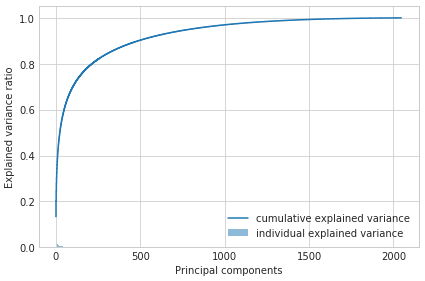

In [18]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(tsvd_var_ratios)), tsvd_var_ratios, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [19]:
# Create Function Calculating Number Of Components Required To Pass Threshold
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [20]:
# Run function
number_of_components = select_n_components(tsvd_var_ratios, 0.95)

In [21]:
truncated_opt_svd = TruncatedSVD(n_components=number_of_components, random_state=42)
transformed_X_train = truncated_opt_svd.fit_transform(X_train)
#transformed_X_test = truncated_opt_svd.transform(X_test)

In [22]:
X = transformed_X_train
#X = transformed_data
Y = train_data_labels

In [23]:
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data_labels)
                                               ,train_data_labels)

In [24]:
class_weight_dic = dict(enumerate(class_weight))

In [25]:
class_weight_dic

{0: 1.5050697084917617,
 1: 1.014957264957265,
 2: 0.7980510752688172,
 3: 1.0281385281385282,
 4: 1.3792102206736354,
 5: 0.6478450627386798,
 6: 1.7911010558069382,
 7: 0.8333333333333334,
 8: 0.605249745158002,
 9: 1.7911010558069382,
 10: 0.7671188630490956,
 11: 1.7135642135642135}

In [30]:
np.unique(Y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [33]:
# define 5-fold cross validation test harness
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=25)
cvscores = []
trainScores = []
f1Score = []
num_k_folds = 5
fold_counter = 0
val_conmats = []
val_precisions = []
val_recalls = []
val_f_scores = []
input_dim = number_of_components

cross_model = Sequential()
cross_model.add(Dense(128, input_dim=input_dim, kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001)))
cross_model.add(BatchNormalization())
cross_model.add(Activation('relu'))
cross_model.add(Dropout(0.8))
cross_model.add(Dense(12, kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))
cross_model.add(BatchNormalization())
cross_model.add(Activation('softmax'))

cross_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [34]:
for train, test in kfold.split(X, Y):
    # Fit the model
    cross_model.fit(X[train], to_categorical(Y[train]), epochs=400, batch_size=batch_size, class_weight=class_weight_dic, verbose=0)
    
    y_train_pred = cross_model.predict(X[train])
    y_train_pred = np.argmax(y_train_pred, axis=1)
    
    y_validation_pred = cross_model.predict(X[test])
    y_validation_pred = np.argmax(y_validation_pred, axis=1)
    #y_validation_pred = np.argmax(y_validation_pred, axis=1)
    
    [precision, recall, f_score, _] = precision_recall_fscore_support(Y[test], y_validation_pred)
    #print("Validation k-fold #%d - precision: %f, recallL: %f, f-score: %f" % (fold_counter, precision, recall, f_score))
    
    conmat = confusion_matrix(Y[test], y_validation_pred)
    
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f_scores.append(f_score)
    val_conmats.append(conmat)
    fold_counter = fold_counter + 1
    
    trainScores.append(accuracy_score(Y[train], y_train_pred))
    cvscores.append(accuracy_score(Y[test], y_validation_pred))
    
print("\nAveraging the 5-fold results:")
print("%s: %.2f%%" % ('AVG Train Acc ', np.mean(trainScores) * 100))
print("%s: %.2f%%" % ('AVG Validation Acc ', np.mean(cvscores) * 100))
print("Validation precision - mean: %f, stddev: %f" % (np.mean(val_precisions), np.std(val_precisions)))
print("Validation recall - mean: %f, stddev: %f" % (np.mean(val_recalls), np.std(val_recalls)))
print("Validation f-score - mean: %f, stddev: %f" % (np.mean(val_f_scores), np.std(val_f_scores)))
print("Confusion matrix:")
print (sum(val_conmats).astype(float) / fold_counter)


Averaging the 5-fold results:
AVG Train Acc : 99.92%
AVG Validation Acc : 89.72%
Validation precision - mean: 0.889801, stddev: 0.111146
Validation recall - mean: 0.889017, stddev: 0.108049
Validation f-score - mean: 0.888370, stddev: 0.107060
Confusion matrix:
[[3.0840e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  2.8000e+00 1.6000e-01 1.8320e+01 2.0000e-01 8.0000e-02 2.0000e-01]
 [0.0000e+00 7.6000e+01 3.2000e-01 1.6000e-01 7.6000e-01 0.0000e+00
  2.4000e-01 4.0000e-01 0.0000e+00 0.0000e+00 4.0000e-02 8.0000e-02]
 [4.0000e-02 1.2000e-01 9.7120e+01 0.0000e+00 5.2000e-01 1.2000e-01
  0.0000e+00 1.6000e-01 2.0000e-01 0.0000e+00 4.0000e-01 5.2000e-01]
 [4.0000e-02 0.0000e+00 0.0000e+00 7.1480e+01 3.2000e-01 6.0000e-01
  7.6000e-01 2.4400e+00 2.4000e-01 0.0000e+00 1.0400e+00 8.0000e-02]
 [0.0000e+00 2.8000e-01 2.4000e-01 5.6000e-01 5.4200e+01 4.0000e-01
  4.0000e-02 5.6000e-01 4.0000e-02 0.0000e+00 6.4000e-01 4.4000e-01]
 [8.0000e-02 0.0000e+00 1.0000e+00 4.8000e-01 1.2000

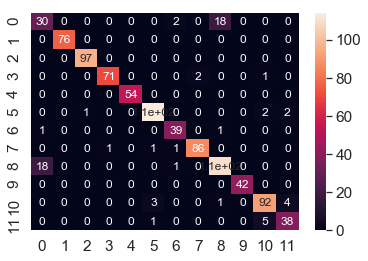

In [36]:
confusion_matrix_array = (sum(val_conmats).astype(float) / fold_counter)
new_confusion_matrix_array = []
for conf_sub_array in confusion_matrix_array:
    new_confusion_matrix_array.append([int(float(e)) for e in conf_sub_array])
        
df_cm = pd.DataFrame(new_confusion_matrix_array, range(12), range(12))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})# font size

In [39]:
test_image_list = os.listdir(test_dir)

In [54]:
def generate_testXY(size=224):
    test_pred_list = []
    label_names = []

    for index, relative_path in enumerate(test_image_list):
        if relative_path == 'Thumbs.db':
            continue
        source = test_dir + relative_path
        img = image.load_img(source, target_size=(image_width, image_height))
        img_x = image.img_to_array(img)
        img_x = np.expand_dims(img_x, axis=0)
        resnet50_x = preprocess_input(img_x)
        resnet50_extract_features = model.predict(resnet50_x)
        resnet50_feature_vector = resnet50_extract_features.flatten()
        scaled_flattern_feature_vector = scaler.transform(np.array([resnet50_feature_vector]))
        transformed_flattern_feature_vector = truncated_opt_svd.transform(scaled_flattern_feature_vector)
        prob = cross_model.predict(transformed_flattern_feature_vector)
        pred = prob.argmax(axis=-1)

        label_names.append(relative_path)
        test_pred_list.append(pred[0])
        #labels.append(int(level))
            
    return np.array(test_pred_list), np.array(label_names)

In [53]:
generate_testXY()

2
[array([2], dtype=int64)]


In [55]:
predictions, label_list = generate_testXY()

# Predictions
# prob = cross_model.predict(transformed_X_test, verbose=1)
# pred = prob.argmax(axis=-1)

submission_df = pd.DataFrame({
    "file": [label for label in label_list],
    "species": [INV_CLASS[p] for p in predictions]
})

In [56]:
submission_df.head()

,file,species
0,0021e90e4.png,Cleavers
1,003d61042.png,Maize
2,007b3da8b.png,Common Chickweed
3,0086a6340.png,Fat Hen
4,00c47e980.png,Common Chickweed


In [57]:
submission_df.to_csv('D:/Neural_nets_course_Dataset/all/output/custom/submission_resnet.csv', index=False, header=True)